# 

In [1]:
import os
import torch
import pickle
from matplotlib import pyplot as plt

In [2]:
def plot_acc(training_name, n_samples):
    output_dir = '../data/outputs'
    filename = os.path.join(output_dir, training_name, f'classification/predictions_{n_samples}_samples')

    with open(filename, 'rb') as f:
        data = pickle.load(f)

    def acc(y, yhat):
        return 100. * torch.sum(y == yhat) / yhat.shape[0]

    t, score = [], []

    for e in sorted(data.keys()):
        predictions_df = data[e]['df']
        y = torch.tensor(predictions_df['true_label'])
        l1_pred = torch.tensor(predictions_df['l1_label_pred'])
        l2_pred = torch.tensor(predictions_df['l2_label_pred'])

        best = max(acc(l1_pred, y), acc(l2_pred, y))
        t.append(e)
        score.append(best)

    training_samples = training_name.split('-')[5]
    print(score)
    plt.plot(t, score, '-*',label=training_samples)

[tensor(68.9453)]


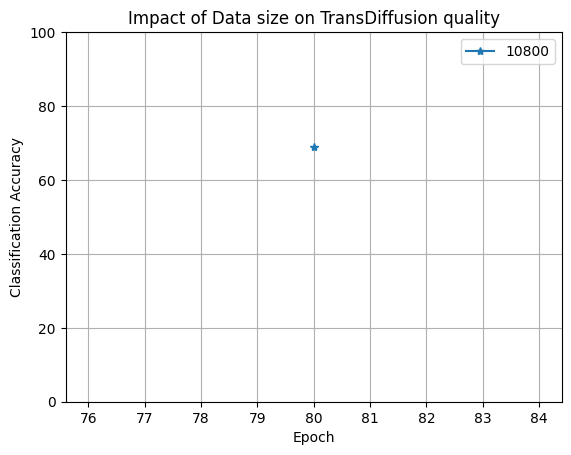

In [5]:
trained_models = [
# '2024-05-10T22-04-53_imagenet-256',
# '2024-05-10T21-25-21_imagenet-512',
# '2024-05-10T17-04-36_imagenet-1024',
# '2024-05-10T19-48-18_imagenet-2048',
# '2024-05-16T21-28-23_imagenet-4096-50-epochs'
# '2024-05-17T15-29-58_imagenet-1024-80-epochs-fixed-cycles',
# '2024-05-17T21-13-47_imagenet-4096-80-epochs-fixed-cycles',
    '2024-06-01T09-24-37_imagenet-10800-80-epochs-fixed-cycles'
    
]

n_samples = 512

for training_name in trained_models:
    plot_acc(training_name, n_samples)

plt.title('Impact of Data size on TransDiffusion quality')
plt.ylabel('Classification Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid('on')
plt.ylim(0, 100)
plt.show()

In [ ]:
# confusion matrix plotter

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# def labels_to_human_labels(labels, human_labels_list):
#     human_labels = [human_labels_list[int(x.detach().cpu().numpy())] for x in labels]  
#     return human_labels

# def plot_confusion_matrix(true_labels, labels_pred, human_labels_list):
#     true_labels_readable = labels_to_human_labels(true_labels, human_labels_list)
#     labels_pred_readable = labels_to_human_labels(labels_pred, human_labels_list)
#     cm = confusion_matrix(true_labels_readable, labels_pred_readable, labels=human_labels_list)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                   display_labels=human_labels_list)
#     fig, ax = plt.subplots(figsize=(12,12))
#     disp.plot(ax=ax)
#     plt.show()

In [4]:
n_samples = 2048
output_dir = '../data/outputs'
filename = os.path.join(output_dir, training_name, f'classification/predictions_{n_samples}_samples')

with open(filename, 'rb') as f:
    data = pickle.load(f)


In [28]:
import pandas as pd
df = data[80]['df']
study_meta_file = '../data/ct-rsna/unified_set_with_study_id.csv'
df_meta = pd.read_csv(study_meta_file)
df_meta[['ID','StudyInstanceUID']]
df.rename(columns={'id': 'ID'}, inplace=True)
df_merged = pd.merge(df, df_meta[['ID', 'StudyInstanceUID']], on='ID', how='left')
grouped = df_merged.groupby('StudyInstanceUID')

for study_id, gdf in grouped:
    print(len(gdf))

2
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
2
2
1
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
4
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
3
1
1
1
1
1
1
3
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
